# Import

In [32]:
import pandas as pd

import numpy as np

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import meanabs
from statsmodels.tools.eval_measures import mse

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import shap

from xgboost import plot_importance
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns


# Load Data

In [33]:
# Load the excel workbook
df = pd.read_excel('/Users/chris/Downloads/Data/df_ml.xlsx')

# Store features and target variable
df = df[['MP','GS','PTS','2P','USG%','G','FT%','FT','Age','AST%','AST','ORB','BLK%','3PAr','3P%','2P%','Salary']]

In [34]:
df.info() # data inspection

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MP      614 non-null    float64
 1   GS      614 non-null    int64  
 2   PTS     614 non-null    float64
 3   2P      614 non-null    float64
 4   USG%    614 non-null    float64
 5   G       614 non-null    int64  
 6   FT%     614 non-null    float64
 7   FT      614 non-null    float64
 8   Age     614 non-null    int64  
 9   AST%    614 non-null    float64
 10  AST     614 non-null    float64
 11  ORB     614 non-null    float64
 12  BLK%    614 non-null    float64
 13  3PAr    614 non-null    float64
 14  3P%     614 non-null    float64
 15  2P%     614 non-null    float64
 16  Salary  614 non-null    int64  
dtypes: float64(13), int64(4)
memory usage: 81.7 KB


# Modelling without Natural Log

## Data Transformation: Divide Target Variable by 1 Million

In [35]:
# Data transformation: divide salary by 1 million
df['Salary'] = df['Salary']/1000000

In [36]:
df.head()

,MP,GS,PTS,2P,USG%,G,FT%,FT,Age,AST%,AST,ORB,BLK%,3PAr,3P%,2P%,Salary
0,32.5,62,14.4,4.2,20.7,62,0.674,2.4,24,17.4,3.7,1.7,1.7,0.309,0.308,0.494,19.863636
1,27.7,50,12.4,3.4,20.7,50,0.651,1.9,25,17.8,3.2,1.5,2.3,0.353,0.335,0.533,18.136364
2,24.5,33,9.5,2.2,18.7,66,0.851,1.1,23,19.1,3.4,0.3,0.9,0.393,0.394,0.427,2.239200
3,17.8,8,7.2,1.6,19.5,66,0.819,1.0,24,14.0,1.9,0.2,0.9,0.417,0.368,0.406,2.345640
4,15.8,6,6.3,1.4,17.0,55,0.773,0.9,26,6.4,0.7,0.3,2.0,0.487,0.375,0.556,1.618520


## Multiple Linear Regression (Conventional Way)

In [6]:
vcvtype = 'nonrobust'

# Define X & y
X = df.drop('Salary',1)
X = sm.add_constant(X)
y = df['Salary']

# Regression 
ols_model = sm.OLS(y, X)
ols_results = ols_model.fit(cov_type=vcvtype)
print(ols_results.summary())


                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     61.46
Date:                Sun, 11 Jul 2021   Prob (F-statistic):          1.07e-114
Time:                        13:57:14   Log-Likelihood:                -1990.8
No. Observations:                 614   AIC:                             4016.
Df Residuals:                     597   BIC:                             4091.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.1392      4.289     -3.996      0.0

### Model Evaluation

In [7]:
# Generate predictions
ypred = ols_results.predict(X) # use reg results to predict X

# Calculate RMSE
rmse = rmse(y, ypred)

# Calculate MSE
mse = mse(y, ypred)

# Calculate MAE
mae = meanabs(y, ypred)

In [8]:
# Evaluation metrics: rmse, mse, mae
print('RMSE:', rmse)
print('MSE:', mse)
print('MAE:', mae)

RMSE: 6.192596148739494
MSE: 38.348247061383205
MAE: 4.649777534929994


## Multiple Linear Regression with Holdout Method

In [9]:
# Define X and y
X = df.drop('Salary',1)
y = df['Salary']

# Splitting to training and testing data

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 24)

In [10]:
# Create a Linear regressor
lr = LinearRegression()

# Train the model using the training sets 
lr.fit(X_train, y_train)

LinearRegression()

In [11]:
# Value of y intercept
lr.intercept_

-19.286241965896494

In [12]:
#Converting the coefficient values to a dataframe
coeffcients = pd.DataFrame([X_train.columns, lr.coef_]).T
coeffcients = coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'})
coeffcients

,Attribute,Coefficients
0,MP,-0.253634
1,GS,0.070880
2,PTS,0.979280
3,2P,-1.304212
4,USG%,0.193324
5,G,-0.058774
6,FT%,-0.594852
7,FT,0.404856
8,Age,0.938813
9,AST%,-0.259827


### Model Evaluation

In [13]:
# Model prediction on train data
y_pred = lr.predict(X_train)

# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
# conclusion: better than the conventional way.

R^2: 0.6498074186359056
Adjusted R^2: 0.6362077067382709
MAE: 4.4782764577670235
MSE: 34.75254881118323
RMSE: 5.895129244654711


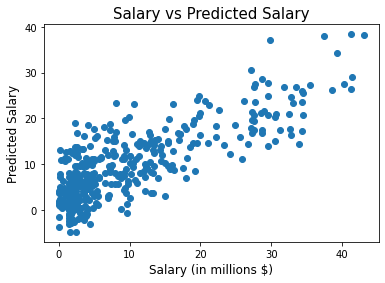

In [14]:
# Visualize the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Salary (in millions $)", fontsize=12)
plt.ylabel("Predicted Salary", fontsize=12)
plt.title("Salary vs Predicted Salary", fontsize=15)
plt.show()

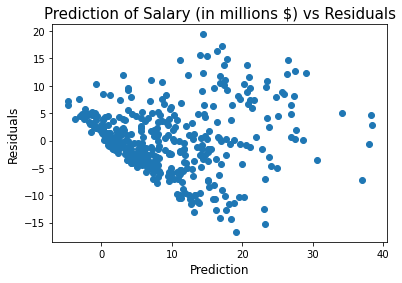

In [15]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Prediction of Salary (in millions $) vs Residuals", fontsize=15)
plt.xlabel("Prediction", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.show()

There seems to be a pattern visible in this plot and values are not distributed equally around zero. So Linearity assumption is not satisfied. Multiple Linear Regression is not appropriate.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


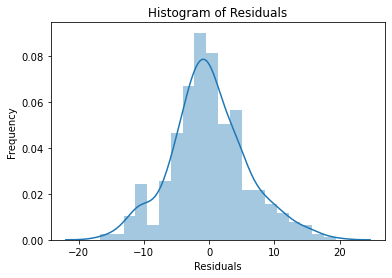

In [16]:
# Checking Normality of errors
sns.distplot(y_train-y_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

Here the residuals are normally distributed. So normality assumption is satisfied



## Random Forest

In [17]:
# Define X and y
X = df.drop('Salary',1)
y = df['Salary']

# Splitting to training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 24)

In [18]:
# Create a Random Forest Regressor
rf = RandomForestRegressor()

# Train the model using the training sets 
rf.fit(X_train, y_train)

RandomForestRegressor()

### Model Evluation

In [19]:
# Model prediction on train data
y_pred = rf.predict(X_train)

In [20]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.9484444877703123
Adjusted R^2: 0.9464423319555672
MAE: 1.5733817099300695
MSE: 5.116286153946142
RMSE: 2.261920899135543


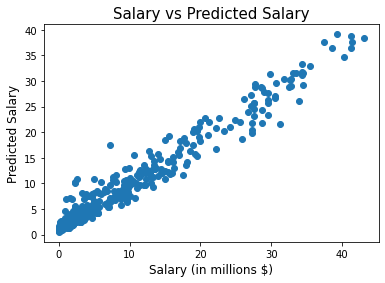

In [21]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Salary (in millions $)", fontsize=12)
plt.ylabel("Predicted Salary", fontsize=12)
plt.title("Salary vs Predicted Salary", fontsize=15)
plt.show()

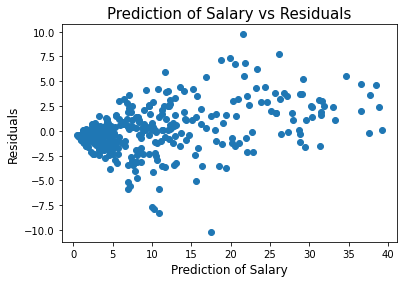

In [22]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Prediction of Salary vs Residuals", fontsize=15)
plt.xlabel("Prediction of Salary", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.show()

### Feature Importance

In [23]:
print("Feature Importances : ", rf.feature_importances_)

Feature Importances :  [0.07553122 0.02738834 0.402587   0.01410044 0.02610304 0.01925253
 0.02682484 0.07825866 0.18087474 0.0382184  0.02552249 0.01808368
 0.01748055 0.0161375  0.01166192 0.02197466]


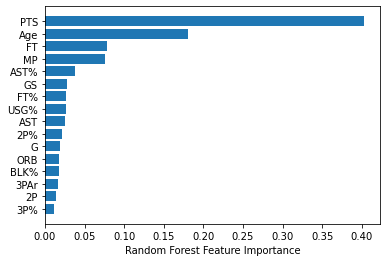

In [24]:
# Create sort
sorted_idx = rf.feature_importances_.argsort()

# Plot
rf_feature_names = X.columns
plt.barh(rf_feature_names[sorted_idx], rf.feature_importances_[sorted_idx], height=0.8)
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [25]:
# Permutation based importance
perm_importance = permutation_importance(rf, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

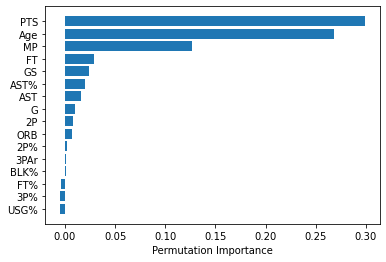

In [26]:
# Create sort
sorted_idx = perm_importance.importances_mean.argsort()

# Plot
plt.barh(rf_feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

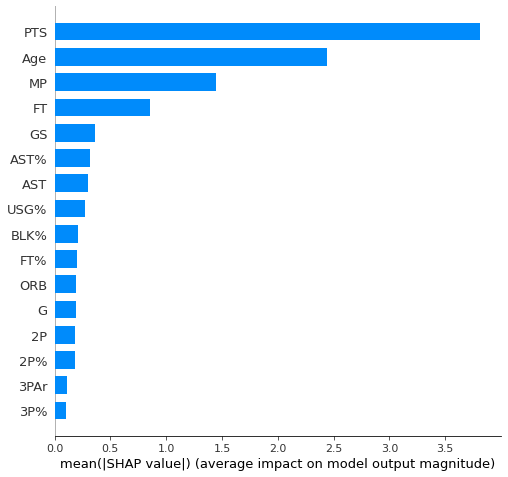

In [27]:
# SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

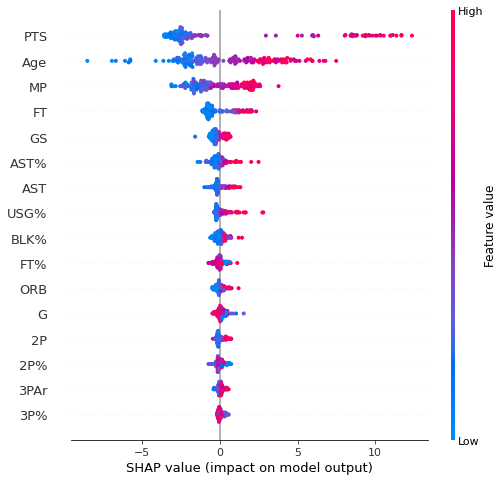

In [28]:
# Summary plot
shap.summary_plot(shap_values, X_test)

## Extra Trees

In [6]:
# Define X and y
X = df.drop('Salary',1)
y = df['Salary']

# Splitting to training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 24)

In [7]:
# Create an extra trees regressor
extra = ExtraTreesRegressor ()

extra.fit(X_train, y_train)

ExtraTreesRegressor()

In [8]:
# Model prediction on train data
y_pred = extra.predict(X_train)

### Model Evaluation

In [9]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 1.0
Adjusted R^2: 1.0
MAE: 9.192659583558588e-15
MSE: 3.052271499891057e-28
RMSE: 1.7470751271456694e-14


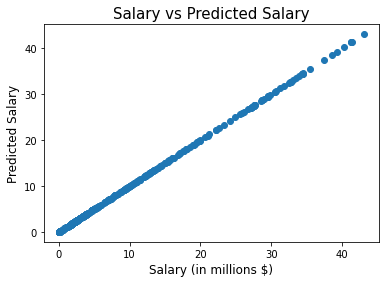

In [10]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Salary (in millions $)", fontsize=12)
plt.ylabel("Predicted Salary", fontsize=12)
plt.title("Salary vs Predicted Salary", fontsize=15)
plt.show()

### Feature Importance

In [11]:
print("Feature Importances : ", extra.feature_importances_)

Feature Importances :  [0.14163052 0.04549849 0.18346306 0.05804261 0.04965731 0.02365341
 0.03093977 0.08785408 0.18004311 0.03052408 0.0735368  0.0215198
 0.01920941 0.01773511 0.01575851 0.02093392]


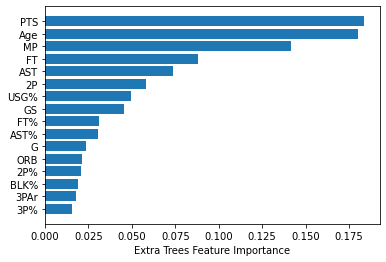

In [12]:
# Create sort
sorted_idx = extra.feature_importances_.argsort()

# Plot
extra_feature_names = X.columns
plt.barh(extra_feature_names[sorted_idx], extra.feature_importances_[sorted_idx], height=0.8)
plt.xlabel("Extra Trees Feature Importance")
plt.show()

In [13]:
# Permutation based importance
perm_importance = permutation_importance(extra, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

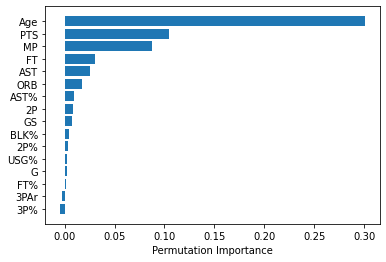

In [14]:
# Create sort
sorted_idx = perm_importance.importances_mean.argsort()

# Plot
plt.barh(extra_feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

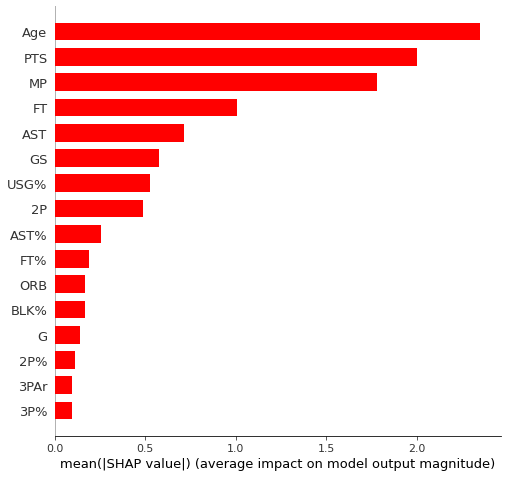

In [15]:
# SHAP
explainer = shap.TreeExplainer(extra)
shap_values = explainer.shap_values(X_test)

# Plot
shap.summary_plot(shap_values, X_test, plot_type="bar",color='red')

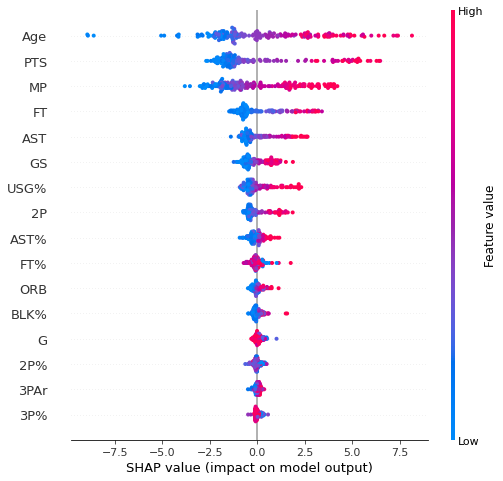

In [16]:
# Summary plot
shap.summary_plot(shap_values, X_test)

In [17]:
shap_values

array([[ 3.99814881,  1.06997995,  2.52648082, ...,  0.22044438,
         0.12980986, -0.26041098],
       [-2.37258132, -0.55976792, -1.78140666, ...,  0.14004722,
         0.10047928,  0.04401528],
       [-0.46226582, -0.49065324, -1.79113278, ...,  0.04204604,
        -0.08455728, -0.05260779],
       ...,
       [-1.02136977, -0.45915646, -0.50699138, ...,  0.08947056,
        -0.03518696, -0.08161833],
       [-0.50594641, -0.50535482,  0.87827135, ...,  0.08287674,
        -0.0194911 ,  0.00634649],
       [-1.84573126, -0.46571975, -1.4143998 , ...,  0.1641147 ,
        -0.05753855,  0.15317021]])

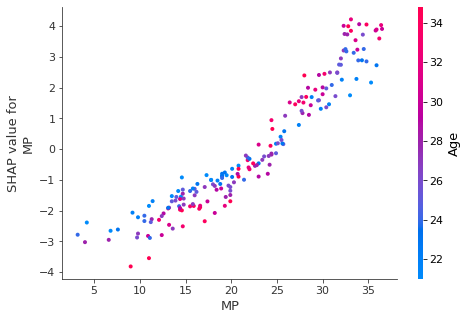

In [18]:
shap.dependence_plot(0,shap_values, X_test)

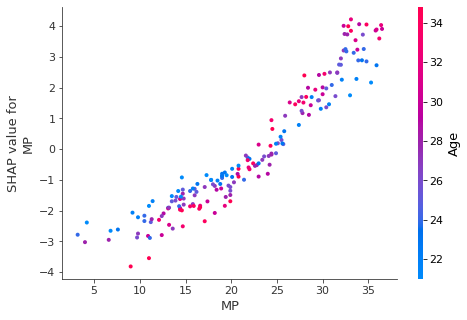

In [19]:
shap.dependence_plot("MP",shap_values, X_test)

### Predict on test set

In [20]:
### Predict on test set
y_pred = extra.predict(X_test)

In [21]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_test, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R^2: 0.6697796927891828
Adjusted R^2: 0.638330139721486
MAE: 4.03323815481081
MSE: 35.259350456033815
RMSE: 5.93795844175705


## Gradient Boosting

In [76]:
X = df.drop('Salary',1)
y = df['Salary']

# Splitting to training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 24)

In [77]:
gb = GradientBoostingRegressor()

gb.fit(X_train, y_train)

GradientBoostingRegressor()

### Model Evaluation

In [78]:
# Model prediction on train data
y_pred = gb.predict(X_train)

In [79]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.9310922839961611
Adjusted R^2: 0.9284162561901868
MAE: 1.9498908643604638
MSE: 6.838290961397556
RMSE: 2.6150126120914896


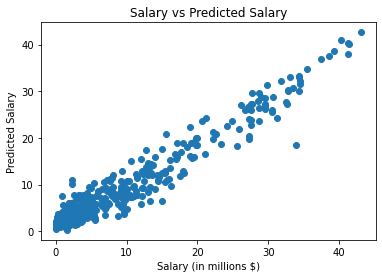

In [80]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Salary (in millions $)")
plt.ylabel("Predicted Salary")
plt.title("Salary vs Predicted Salary")
plt.show()

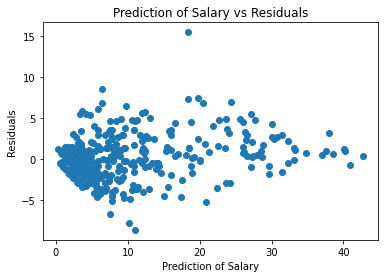

In [81]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Prediction of Salary vs Residuals")
plt.xlabel("Prediction of Salary")
plt.ylabel("Residuals")
plt.show()

### Feature Importance

In [82]:
gb_feature_names = X.columns

Feature Importances :  [0.09278816 0.01955671 0.34808651 0.00730932 0.02847899 0.0051999
 0.0222738  0.11046122 0.21999443 0.0269999  0.03817649 0.02724268
 0.00966215 0.02148833 0.00626346 0.01601794]


Text(0.5, 0, 'Gradient Boosting Feature Importance')

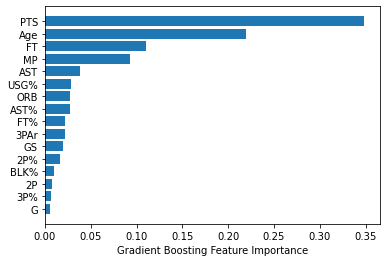

In [83]:
print("Feature Importances : ", gb.feature_importances_)

# plot feature importance
sorted_idx = gb.feature_importances_.argsort()

plt.barh(gb_feature_names[sorted_idx], gb.feature_importances_[sorted_idx])

plt.xlabel("Gradient Boosting Feature Importance")

In [84]:
# Permutation based importance
perm_importance = permutation_importance(extra, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

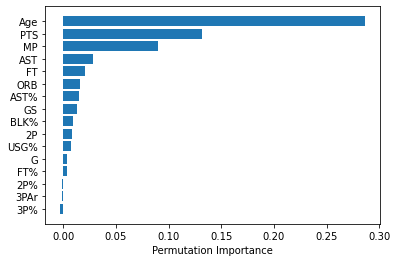

In [85]:
# Create sort
sorted_idx = perm_importance.importances_mean.argsort()

# Plot
plt.barh(extra_feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

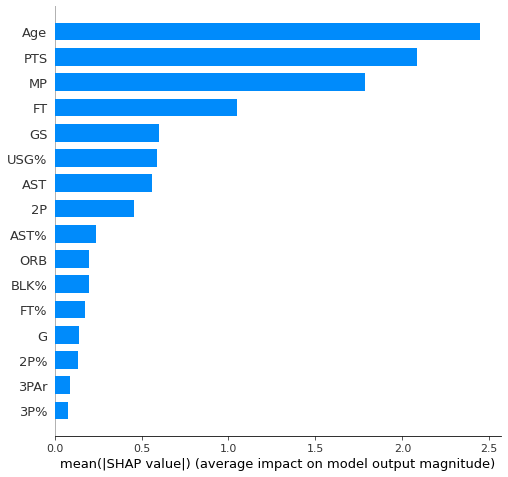

In [86]:
# SHAP
explainer = shap.TreeExplainer(extra)
shap_values = explainer.shap_values(X_test)

# Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

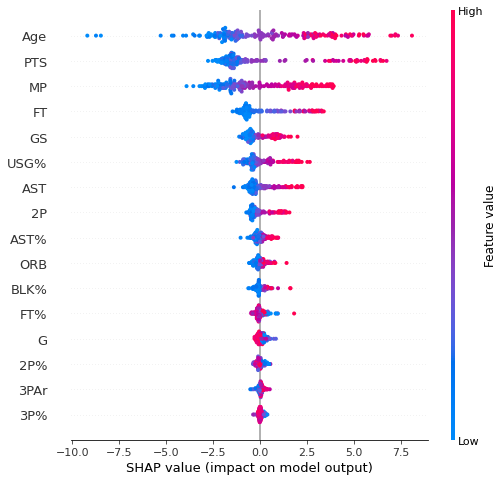

In [87]:
# Summary plot
shap.summary_plot(shap_values, X_test)

## XGB

In [37]:
# Define X and y
X = df.drop('Salary',1)
y = df['Salary']

# Splitting to training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 24)

In [23]:
#Create a XGBoost Regressor
XGB = XGBRegressor()

# Train the model using the training sets 
XGB.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Model Evaluation

In [24]:
# Model prediction on train data
y_pred = XGB.predict(X_train)

In [25]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.9999994794482784
Adjusted R^2: 0.9999994592326775
MAE: 0.004853587081220039
MSE: 5.165871602275188e-05
RMSE: 0.0071873998095800876


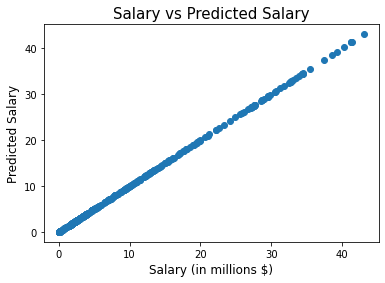

In [26]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Salary (in millions $)", fontsize=12)
plt.ylabel("Predicted Salary", fontsize=12)
plt.title("Salary vs Predicted Salary", fontsize=15)
plt.show()

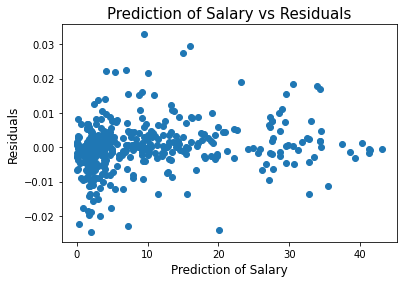

In [27]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Prediction of Salary vs Residuals", fontsize=15)
plt.xlabel("Prediction of Salary", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.show()

### Feature Importance

Feature Importances :  [0.03312683 0.01014896 0.44585302 0.00507129 0.01465864 0.01072169
 0.01104903 0.0482658  0.19925445 0.02679211 0.10423926 0.02651242
 0.01411672 0.01249324 0.01426757 0.02342889]


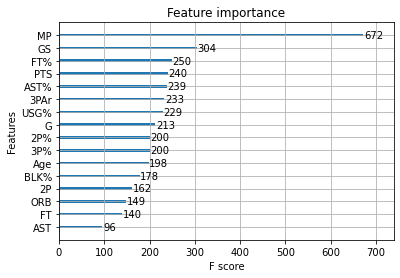

In [28]:
print("Feature Importances : ", XGB.feature_importances_)

# plot feature importance
plot_importance(XGB)
plt.show()

In [29]:
# Permutation based importance
perm_importance = permutation_importance(extra, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

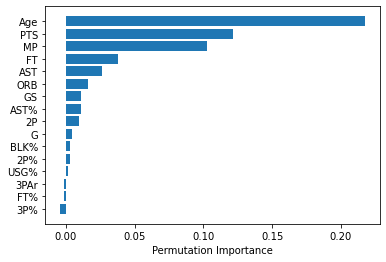

In [30]:
# Create sort
sorted_idx = perm_importance.importances_mean.argsort()

# Plot
plt.barh(extra_feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

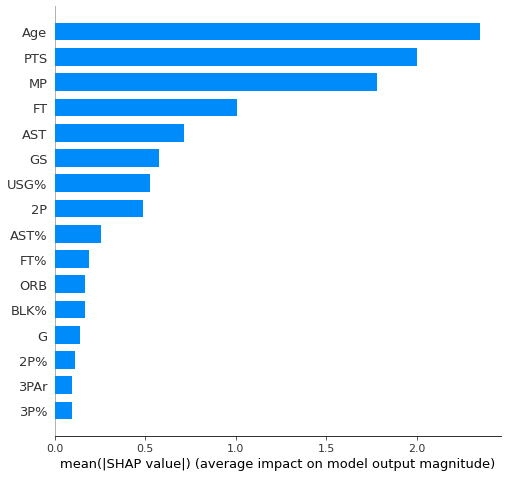

In [31]:
# SHAP
explainer = shap.TreeExplainer(extra)
shap_values = explainer.shap_values(X_test)

# Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

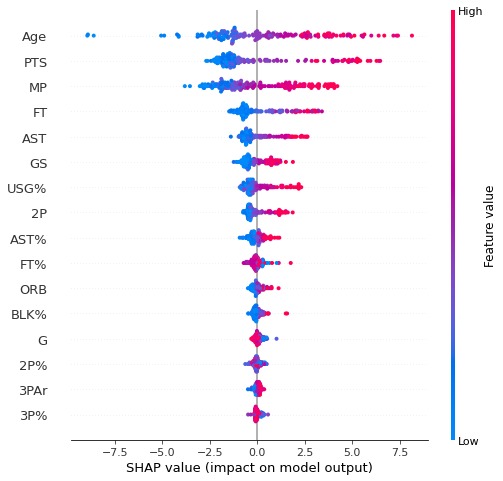

In [32]:
# Summary plot
shap.summary_plot(shap_values, X_test)

### Predict on test set

In [33]:
### Predict on test set
y_pred = XGB.predict(X_test)

In [34]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_test, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R^2: 0.6087021648141737
Adjusted R^2: 0.5714357043202856
MAE: 4.322353633524632
MSE: 41.78091777589036
RMSE: 6.463816038215379


# Hyperparameter Tuning

In [38]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [39]:
num_folds = 10
seed = 24
MSE = 'neg_mean_squared_error'
RMSE = 'neg_root_mean_squared_error'
MAE = 'neg_mean_absolute_error'
r2 = 'r2'

In [40]:
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor()))
models.append(('GB', GradientBoostingRegressor()))
models.append(('XGB', XGBRegressor()))
models.append(('EXT', ExtraTreesRegressor()))

In [41]:
# MSE
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=MSE)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -37.407687 (6.681593)
RF: -36.465202 (7.701167)
GB: -37.098575 (7.617643)
XGB: -40.215904 (5.985586)
EXT: -32.879686 (7.132955)


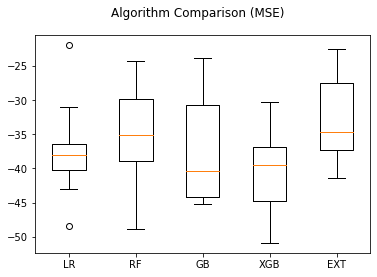

In [134]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison (MSE)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [42]:
# RMSE
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=RMSE)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -6.088885 (0.577203)
RF: -5.923166 (0.615033)
GB: -6.044683 (0.655300)
XGB: -6.323821 (0.474546)
EXT: -5.711291 (0.698136)


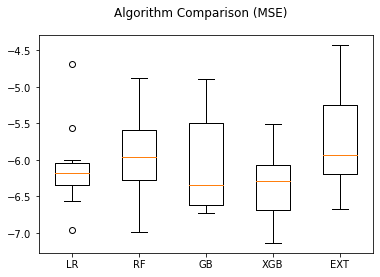

In [114]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison (MSE)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [43]:
# MAE
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=MAE)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -4.660008 (0.519439)
RF: -4.229849 (0.461681)
GB: -4.287874 (0.559553)
XGB: -4.405265 (0.457540)
EXT: -3.954230 (0.444949)


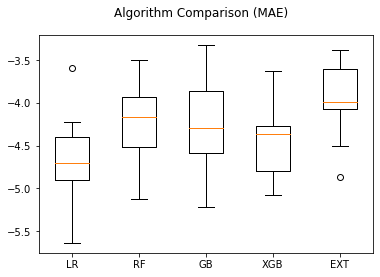

In [44]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison (MAE)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [45]:
# R2
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=r2)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.614833 (0.055951)
RF: 0.638949 (0.068070)
GB: 0.607926 (0.090490)
XGB: 0.578170 (0.082391)
EXT: 0.661731 (0.072745)


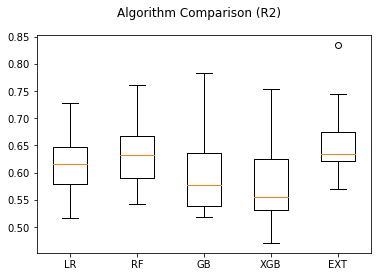

In [46]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison (R2)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [47]:
model = ExtraTreesRegressor()

extratree_para = {"min_samples_split": [2, 6, 20],
             "min_samples_leaf": [1, 4, 16],
             "n_estimators":[50, 100, 500, 1000]            }

tuned_extratree = GridSearchCV(
    estimator=model,
    param_grid=extratree_para,
    scoring=MSE,
    cv=10
)

In [48]:
grid_result = tuned_extratree.fit(X_train, y_train)

In [49]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -31.995742 using {'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}


In [52]:
model = ExtraTreesRegressor()

extratree_para = {"min_samples_split": [2, 6, 20],
             "min_samples_leaf": [1, 4, 16],
             "n_estimators":[50, 100, 500, 1000]            }

tuned_extratree = GridSearchCV(
    estimator=model,
    param_grid=extratree_para,
    scoring=RMSE,
    cv=10
)

In [53]:
grid_result = tuned_extratree.fit(X_train, y_train)

In [54]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -5.613665 using {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


### Predict on Test Set

In [50]:
y_pred = tuned_extratree.predict(X_test)

In [51]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_test, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R^2: 0.6626143861085672
Adjusted R^2: 0.6304824228808117
MAE: 4.096728604266667
MSE: 36.02442775097891
RMSE: 6.002035300710827


# Modelling with Natural Log

In [12]:
# Load the excel workbook
df = pd.read_excel('/Users/chris/Downloads/Data/df_ml.xlsx')

# Store features and target variable
df = df[['MP','GS','PTS','2P','USG%','G','FT%','FT','Age','AST%','AST','ORB','BLK%','3PAr','3P%','2P%','Salary']]

In [13]:
y = np.log(df['Salary'])
X = df.drop('Salary', 1)

In [19]:
# Splitting to training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 24)

## Multiple Linear Regression

In [20]:
# Create a Linear regressor
lr_log = LinearRegression()

# Train the model using the training sets 
lr_log.fit(X_train, y_train)

LinearRegression()

In [21]:
# Model prediction on train data
y_pred = lr_log.predict(X_train)

# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))


R^2: 0.5789421211871881
Adjusted R^2: 0.5625903589031955
MAE: 0.6476170555599171
MSE: 0.7084894906262973
RMSE: 0.841718177673678


## Random Forest

In [97]:
# Create a Random Forest Regressor
rf_log = RandomForestRegressor()

# Train the model using the training sets 
rf_log.fit(X_train, y_train)

RandomForestRegressor()

### Model Evaluation

In [98]:
y_pred = rf_log.predict(X_train)

In [99]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.9331651719188133
Adjusted R^2: 0.9305696446146896
MAE: 0.25008701471212075
MSE: 0.11245906011032532
RMSE: 0.3353491614874343


## Extra Trees

In [100]:
# Create an extra trees regressor
extra_log = ExtraTreesRegressor ()

extra_log.fit(X_train, y_train)

ExtraTreesRegressor()

### Model Evaluation

In [104]:
# Model prediction on train data
y_pred = extra_log.predict(X_train)

In [105]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
# conclusion: applying log does not improve the model

R^2: 1.0
Adjusted R^2: 1.0
MAE: 1.7650734538819154e-12
MSE: 6.555126315775416e-22
RMSE: 2.5602980911947376e-11


## Gradient Boosting

In [109]:
gb_log = GradientBoostingRegressor()

gb_log.fit(X_train, y_train)

GradientBoostingRegressor()

In [110]:
# Model prediction on train data
y_pred = gb_log.predict(X_train)

### Model Evaluation

In [111]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
# conclusion: applying log does not improve the model

R^2: 0.8873007420594546
Adjusted R^2: 0.8829240718481713
MAE: 0.33587327282385004
MSE: 0.1896324564152274
RMSE: 0.4354680888598238


## XGB

In [86]:
#Create a XGBoost Regressor
XGB_log = XGBRegressor()

# Train the model using the training sets 
XGB_log.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Model Evaluation

In [88]:
# Model prediction on train data
y_pred = XGB_log.predict(X_train)

In [89]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
# conclusion: applying log does not improve the model

R^2: 0.9999982543094128
Adjusted R^2: 0.9999981865156036
MAE: 0.0011527522495938204
MSE: 2.937371551954351e-06
RMSE: 0.001713876177544443
